<a href="https://colab.research.google.com/github/crimama/Bigdata_course/blob/Bigdata_course/%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN을 이용한 흑백 mnist 분류 문제 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Input

import time

# 데이터 호출 및 데이터 확인 

In [3]:
(raw_train_x, raw_train_y), (raw_test_x, raw_test_y) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


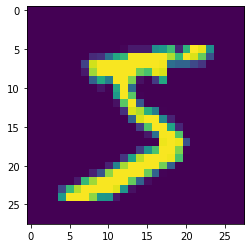

In [6]:
plt.imshow(raw_train_x[0])

In [14]:
train_x.shape

(60000, 28, 28)

In [15]:
set(train_y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [11]:
train_x = raw_train_x/255
train_y = raw_train_y

test_x = raw_test_x/255
test_y = raw_test_y 

# 콜백 선언 

In [16]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

    #call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=50)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=25,        # 대상 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율


#아래 이것만 설정 해주면 됨, [] 안에 사용할 것만 넣어서 쓰면 됨 
callbacks = [model_check_point, plot_losses, early_stopping, reduce_lr]

# 모델링 

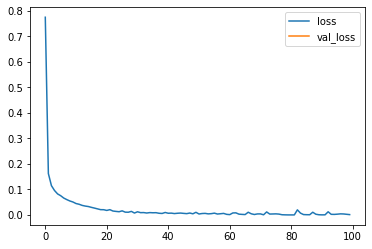

loss =  0.0013679692056030035 , val_loss =  None
313/313 [==============================] - 1s 3ms/step - loss: 0.1519 - accuracy: 0.9823
loss= 0.15187299251556396
acc= 0.9822999835014343
[7 2 1 ... 4 5 6]


In [17]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, Reshape

import time

model = keras.Sequential()
model.add(Input((28,28)))
model.add(Reshape((28,28,1)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

model.fit(train_x,train_y, batch_size = 128, epochs = 100, callbacks = callbacks, verbose = 1 ,validation_split = 0.2)


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)

# CNN 실습- 강아지 고양이 분류 

## 데이터 호출  - 모듈을 사용 해서 호출 

In [88]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import vgg16

def load_file_names_and_category_names(path):
  
  file_names = []
  category_names = []

  dir_names = os.listdir(path)
      
  for dir_name in dir_names:
    file_names_in_a_dir = os.listdir(path+"/"+dir_name)

    for a_file_name in file_names_in_a_dir:
      full_file_name = path+"/"+dir_name+"/"+a_file_name
      file_names.append(full_file_name)
      category_names.append(dir_name)

  combined = list(zip(file_names, category_names))
  random.shuffle(combined)
  file_names, category_names = zip(*combined)

  return file_names, category_names


def load_image_files_into_numpy_array(file_names):
  file_count = len(file_names)    
  data = np.ndarray(shape=(file_count,224,224,3), dtype=np.float64)    
  for i in range(len(file_names)):
    image = load_img(file_names[i], target_size=(224, 224))
    image = img_to_array(image)
    data[i] = image
  return data


def load_custom_data(path, train_ratio=0.8):
  
  file_names, category_names = load_file_names_and_category_names(path)
  x = load_image_files_into_numpy_array(file_names)
  
  labels, y = np.unique(category_names, return_inverse=True)  

  s = int(x.shape[0]*train_ratio)
  train_x, test_x = x[:s], x[s:]
  train_y, test_y = y[:s], y[s:]
  
  return (train_x, train_y), (test_x, test_y), labels



In [89]:
(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("/content/drive/MyDrive/데이터 보관/강아지고양이/cat_and_dog/train") #<-------- 폴더 - 클래스 - 파일 
train_x = vgg16.preprocess_input(train_x)
test_x = vgg16.preprocess_input(test_x)

# 여기의 cat dog 파일은 train, test가 나눠 져 있으므로 train만을 이용해 train, test 를 나누면 아래와는 다른 결과가 나옴 

In [19]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import VGG16

conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])


(train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("/content/drive/MyDrive/데이터 보관/강아지고양이/cat_and_dog/train") #<-------- path만 바꿔 주면 됨 : 폴더 - 클래스 - 파일 
train_x = vgg16.preprocess_input(train_x)
test_x = vgg16.preprocess_input(test_x)


model.fit(train_x, train_y, epochs=10, batch_size=64, shuffle=True,validation_split = 0.1)


loss, acc = model.evaluate(test_x, test_y)
print("loss =",loss)
print("acc =",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)
print(predicted[0], custom_labels[predicted[0]])




Epoch 1/10
6/6 [==============================] - 8s 1s/step - loss: 281.6847 - acc: 0.6203 - val_loss: 0.7443 - val_acc: 0.9487
Epoch 2/10
6/6 [==============================] - 1s 147ms/step - loss: 0.8628 - acc: 0.9913 - val_loss: 1.7336 - val_acc: 0.9744
Epoch 3/10
6/6 [==============================] - 1s 150ms/step - loss: 3.1373 - acc: 0.9623 - val_loss: 0.5984 - val_acc: 0.9744
Epoch 4/10
6/6 [==============================] - 1s 149ms/step - loss: 0.6248 - acc: 0.9942 - val_loss: 78.0789 - val_acc: 0.7692
Epoch 5/10
6/6 [==============================] - 1s 153ms/step - loss: 1.3775 - acc: 0.9884 - val_loss: 2.0461 - val_acc: 0.9744
Epoch 6/10
6/6 [==============================] - 1s 146ms/step - loss: 0.2011 - acc: 0.9971 - val_loss: 8.1339 - val_acc: 0.9487
Epoch 7/10
6/6 [==============================] - 1s 151ms/step - loss: 1.9247 - acc: 0.9855 - val_loss: 0.3073 - val_acc: 0.9744
Epoch 8/10
6/6 [==============================] - 1s 157ms/step - loss: 0.0000e+00 - acc: 

## 데이터 호출 - 디렉토리 사용 

In [17]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import VGG16


conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])


# (train_x, train_y), (test_x, test_y), custom_labels = load_custom_data("dogs")

# train_x = vgg16.preprocess_input(train_x)
# test_x = vgg16.preprocess_input(test_x)


# ADD START
train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory( #<------------ 이미지 데이터 제너레이터에 이 부분이 추가 됨 
      "/content/drive/MyDrive/데이터 보관/강아지고양이/cat_and_dog/train", #<------- 디렉토리를 넣으면 됨 , 디렉토리 구조 : train 폴더 - class 폴더 - 이미지 
      target_size=(224,224),
      batch_size=64,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=vgg16.preprocess_input
).flow_from_directory(
      "/content/drive/MyDrive/데이터 보관/강아지고양이/cat_and_dog/test",
      target_size=(224,224),
      batch_size=64,      
      class_mode='sparse'
)


# ADD END
 

#model.fit(train_x, train_y, epochs=10, batch_size=64, shuffle=True)
model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      epochs=10
)

# loss, acc = model.evaluate(test_x, test_y)
loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)

# y_ = model.predict(test_x)
y_ = model.predict(test_data_generator)

custom_labels = list(test_data_generator.class_indices.keys()) # ADDED
predicted = np.argmax(y_, axis=1)
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


58900480/58889256 [==============================] - 0s 0us/step
Found 480 images belonging to 2 classes.
Found 122 images belonging to 2 classes.
Epoch 1/10
8/8 [==============================] - 84s 10s/step - loss: 240.6165 - acc: 0.6938 - val_loss: 4.3507 - val_acc: 0.9754
Epoch 2/10
8/8 [==============================] - 7s 902ms/step - loss: 3.0879 - acc: 0.9729 - val_loss: 6.9227 - val_acc: 0.9426
Epoch 3/10
8/8 [==============================] - 7s 900ms/step - loss: 2.1402 - acc: 0.9667 - val_loss: 3.1742 - val_acc: 0.9672
Epoch 4/10
8/8 [==============================] - 7s 970ms/step - loss: 0.7726 - acc: 0.9812 - val_loss: 5.3764 - val_acc: 0.9426
Epoch 5/10
8/8 [==============================] - 7s 899ms/step - loss: 0.9702 - acc: 0.9854 - val_loss: 2.8263 - val_acc: 0.9672
Epoch 6/10
8/8 [==============================] - 7s 906ms/step - loss: 0.4287 - acc: 0.9833 - val_loss: 3.2705 - val_acc: 0.9590
Epoch 7/10
8/8 [==============================] - 7s 903ms/step - loss: 

## 데이터 호출 - cv2 를 활용 

In [30]:
# 파일리스트
import glob
cat_path = "/content/drive/MyDrive/데이터 보관/강아지고양이/cat_and_dog/train/Cat/*.jpg"
cat_file_list = glob.glob(cat_path)

In [35]:
#train_cat 파일 리스트 
import glob 
cat_train_path = "/content/drive/MyDrive/데이터 보관/강아지고양이/cat_and_dog/train/Cat/*.jpg"
cat_test_path = '"/content/drive/MyDrive/데이터 보관/강아지고양이/cat_and_dog/test/Cat/*.jpg"'
dog_train_path = "/content/drive/MyDrive/데이터 보관/강아지고양이/cat_and_dog/train/Dog/*.jpg"
dog_test_path = "/content/drive/MyDrive/데이터 보관/강아지고양이/cat_and_dog/test/Dog/*.jpg"

In [108]:
#파일 리스트에서 데이터 호출하는 사용자 정의 함수 

def file_list_get(path):
  file_list = glob.glob(path)
  return file_list

def image_get(file_list):
  import cv2 
  image_list = []
  for i in range(len(file_list)):
    image = cv2.imread(file_list[i])
    image_list.append(image)
  return image_list

def resize_cvt(image_list):
  bf_image = image_list
  changed_image_list = []
  for i in range(len(bf_image)):
    changed_image = cv2.cvtColor(bf_image[i],cv2.COLOR_BGR2RGB)
    changed_image = cv2.resize(changed_image, dsize=(224,224))
    changed_image_list.append(changed_image)
  return changed_image_list

def get_resized_image(path):
  file_list = file_list_get(path)
  image = image_get(file_list)
  resized_image = resize_cvt(image)
  return resized_image


In [112]:
# 데이터 생성 
cat_train = get_resized_image(cat_train_path)
dog_train = get_resized_image(dog_train_path)
cat_test = get_resized_image(cat_test_path)
dog_test = get_resized_image(dog_test_path)

In [136]:
#train 용 데이터 생성 
raw_y =[0]*240 + [1]*240
raw_y = np.array(raw_y).reshape(-1,1)
raw_x = cat_train + dog_train
raw_x = np.array(raw_x)

In [138]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y,test_y = train_test_split(raw_x, raw_y, shuffle = True, train_size = 0.8)

In [140]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import VGG16

conv_layers = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])


train_x = vgg16.preprocess_input(train_x)
test_x = vgg16.preprocess_input(test_x)


model.fit(train_x, train_y, epochs=10, batch_size=64, shuffle=True,validation_split = 0.1)


loss, acc = model.evaluate(test_x, test_y)
print("loss =",loss)
print("acc =",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)
print(predicted[0], custom_labels[predicted[0]])




Epoch 1/10
6/6 [==============================] - 2s 213ms/step - loss: 346.6988 - acc: 0.6174 - val_loss: 12.1063 - val_acc: 0.8974
Epoch 2/10
6/6 [==============================] - 1s 140ms/step - loss: 4.2665 - acc: 0.9478 - val_loss: 0.2247 - val_acc: 0.9744
Epoch 3/10
6/6 [==============================] - 1s 136ms/step - loss: 0.2327 - acc: 0.9942 - val_loss: 0.1007 - val_acc: 0.9744
Epoch 4/10
6/6 [==============================] - 1s 137ms/step - loss: 0.0677 - acc: 0.9913 - val_loss: 1.3976 - val_acc: 0.9487
Epoch 5/10
6/6 [==============================] - 1s 137ms/step - loss: 0.2123 - acc: 0.9855 - val_loss: 1.0867 - val_acc: 0.9744
Epoch 6/10
6/6 [==============================] - 1s 136ms/step - loss: 0.1510 - acc: 0.9884 - val_loss: 1.1715 - val_acc: 0.9744
Epoch 7/10
6/6 [==============================] - 1s 137ms/step - loss: 0.3170 - acc: 0.9884 - val_loss: 0.5956 - val_acc: 0.9487
Epoch 8/10
6/6 [==============================] - 1s 137ms/step - loss: 0.1151 - acc: 0

In [142]:
y_ = model.predict(test_x)
predicted = np.argmax(y_,axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


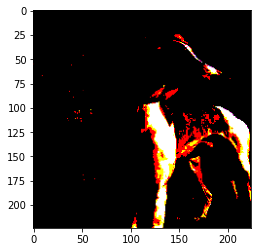

In [150]:
plt.imshow(test_x[0])

In [153]:
for i in range(len(test_y)):
  print(f'predict = {predicted[i]}')
  print(f'true = {test_y[i]}')
  plt.show()

predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 0
true = [0]
predict = 0
true = [0]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 0
true = [0]
predict = 0
true = [0]
predict = 0
true = [0]
predict = 0
true = [0]
predict = 1
true = [1]
predict = 0
true = [0]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 1
true = [1]
predict = 0
true = [0]
predict = 0
true = [0]
predict = 1
true = [1]
predict = 0
true = [0]
predict = 0
true = [0]
predict = 0
true = [0]
predict = 0
true = [0]
predict = 0
true = [0]
predict = 0
true = [0]
predict = 1
true = [1]
predict = 0
true = [0]
predict = 0
true = [0]
predict = 0
true = [0]
predict = 0